<a href="https://colab.research.google.com/github/engelsm/mless_fork/blob/main/homework2/Task_3_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*#author* Marlon Engels

This is a copy of 'Task_2_MLP' where only the last cells are new. Most of this file contains my code, and thus I will not separately mark my contributions but rather explain when code is taken from existing notebooks.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Import normalized dataset and drop columns that are not needed
variable_column = ["temp","o3"]
TIMESERIES_DATA_DIR = "/content/drive/MyDrive/mless/"
dataframe = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
dataframe = dataframe.drop(columns=["no2","no","press"])
dataframe.head()

,longitude,latitude,station_code,datetime,o3,temp
0,6.093923,50.754704,DENW094,1997-01-01 00:00:00+00:00,-1.686509,-3.566220
1,6.093923,50.754704,DENW094,1997-01-01 01:00:00+00:00,-1.686509,-3.633418
2,6.093923,50.754704,DENW094,1997-01-01 02:00:00+00:00,-1.686509,-3.646857
3,6.093923,50.754704,DENW094,1997-01-01 03:00:00+00:00,-1.686509,-3.740934
4,6.093923,50.754704,DENW094,1997-01-01 04:00:00+00:00,-1.686509,-3.767813


In [15]:
# The dataset unfortunately has duplicate values for identical station code + datetime combinations, thus we need to clean this up
def clean_duplicate_timestamps(data, variable_columns):
    """
    Aggregate rows with duplicate station code + datetime, taking the mean of variable_columns
    and the first value of longitude and latitude.

    Args:
        data (pd.DataFrame): Input DataFrame with columns station_code, datetime, variable_columns, longitude, latitude
        variable_columns (list): List of column names to aggregate with mean

    Returns:
        pd.DataFrame: Cleaned DataFrame with no duplicate station_code/datetime pairs
    """
    data = data.copy()
    data['datetime'] = pd.to_datetime(data['datetime'])

    # Columns to aggregate: mean for variable_columns, first for lon/lat
    agg_cols = {col: 'mean' for col in variable_columns}
    agg_cols.update({'longitude': 'first', 'latitude': 'first'})

    # Group by station_code and datetime, aggregate specified columns
    data_clean = data.groupby(['station_code', 'datetime'], as_index=False).agg(agg_cols)

    return data_clean

data_clean = clean_duplicate_timestamps(dataframe, variable_columns=["o3","temp"])
data_clean.shape

(148435, 6)

In [16]:
from sklearn.metrics import mean_squared_error

# This function is identical to the one in '3_AutoRegressive_Models.ipynb'
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, variable_column, n_past=336, n_future=96):
    df = data.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['station_code', 'datetime']).reset_index(drop=True)

    # 1) Encode station_code as a small integer (categorical codes) to save memory
    df['sc_code'] = df['station_code'].astype('category')

    # 2) Boolean mask: True if exactly 1 hour after the previous row (per station)
    is1h = (
        df.groupby('station_code')['datetime']
          .diff()
          .eq(pd.Timedelta(hours=1))
    )

    # 3) Compute how many consecutive “True” over (n_past + n_future - 1) rows
    gap_window = n_past + n_future - 1
    run = (
        is1h.groupby(df['station_code'])
            .rolling(window=gap_window, min_periods=gap_window)
            .sum()
            .reset_index(level=0, drop=True)
    )

    # 4) 'ends' are indices where run == gap_window (end of a full-length continuous block)
    ends = run[run == gap_window].index

    # 5) Grab column‐arrays for encoded station code and the variable
    sc_arr  = df['sc_code'].values
    vals    = df[variable_column].values

    X_list = []
    y_list = []
    for end_idx in ends:
        start_idx = end_idx - gap_window
        if start_idx >= 0 and sc_arr[start_idx] == sc_arr[end_idx]:
            station_block = sc_arr[start_idx : end_idx + 1]
            var_block     = vals[start_idx : end_idx + 1]

            block = np.column_stack((station_block, var_block))

            X_list.append(block[:n_past, :])
            y_list.append(block[n_past:, :])

    if not X_list:
        # No valid windows
        return np.empty((0, n_past, 2)), np.empty((0, n_future, 2))

    X = np.stack(X_list)  # shape = (num_windows, n_past, 2)
    y = np.stack(y_list)  # shape = (num_windows, n_future, 2)
    return X, y

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [17]:
# Create a train/test split just like in '3_AutoRegressive_Models.ipynb'
context_window = 336
prediction_horizon = 96

X, y = create_sequences(data_clean,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (21493, 336, 3), y_train shape: (21493, 96, 3)
X_test shape: (9212, 336, 3), y_test shape: (9212, 96, 3)


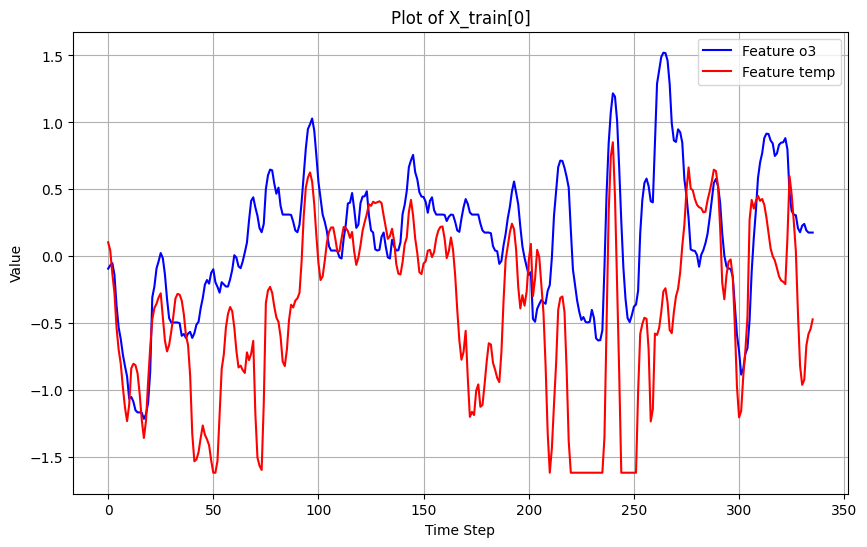

In [18]:
# Informative plot to visualize the correlation between o3 and temp values
sample = X_train[0]  # Shape: (336, 3)

feature_1 = sample[:, 1]
feature_2 = sample[:, 2]

plt.figure(figsize=(10, 6))
plt.plot(feature_1, label='Feature o3', color='blue')
plt.plot(feature_2, label='Feature temp', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Plot of X_train[0]')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Preparing input data for training with the MLP which expects a certain format

# Extract O3 and temperature from X_train and X_test (ignore station ID)
X_train_o3_temp = X_train[:, :, 1:]  # Shape: (21493, 336, 2)
X_test_o3_temp = X_test[:, :, 1:]   # Shape: (9212, 336, 2)

# Reshape X to 2D: (samples, time_steps * features)
X_train_flat = X_train_o3_temp.reshape(X_train_o3_temp.shape[0], -1)  # Shape: (21493, 336*2 = 672)
X_test_flat = X_test_o3_temp.reshape(X_test_o3_temp.shape[0], -1)    # Shape: (9212, 672)

# Extract O3 from y_train and y_test (target variable)
y_train_o3 = y_train[:, :, 1]  # Shape: (21493, 96)
y_test_o3 = y_test[:, :, 1]    # Shape: (9212, 96)

X_train_flat.shape, X_test_flat.shape, y_train_o3.shape, y_test_o3.shape

((21493, 672), (9212, 672), (21493, 96), (9212, 96))

In [20]:
#MLP needs numeric types
X_train_flat = np.array(X_train_flat, dtype=np.float32, copy=True)
X_test_flat = np.array(X_test_flat, dtype=np.float32, copy=True)
y_train_o3 = np.array(y_train_o3, dtype=np.float32, copy=True)
y_test_o3 = np.array(y_test_o3, dtype=np.float32, copy=True)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Define hyperparameters
mlp_hidden_units = [512, 256, 128]  # Hidden layer sizes
activation_fn = 'relu'              # Activation function
mlp_optim = 'adam'                  # Optimizer
mlp_loss = 'mse'                    # Loss function
mlp_epochs = 50                     # Number of epochs
mlp_batch_size = 32                 # Batch size

# Build MLP model
mlp_model = Sequential([
    Input(shape=(X_train_flat.shape[1],)),  # Input: 336*2 = 672 features
    Dense(mlp_hidden_units[0], activation=activation_fn)
])

for units in mlp_hidden_units[1:]:
    mlp_model.add(Dense(units, activation=activation_fn))

mlp_model.add(Dense(y_train_o3.shape[1]))  # Output: 96 O3 values

# Compile model
mlp_model.compile(optimizer=mlp_optim, loss=mlp_loss, metrics=['mae'])

# Train model
training = mlp_model.fit(
    X_train_flat, y_train_o3,
    epochs=mlp_epochs,
    batch_size=mlp_batch_size,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3929 - mae: 0.4742 - val_loss: 0.3523 - val_mae: 0.4703
Epoch 2/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2014 - mae: 0.3476 - val_loss: 0.3713 - val_mae: 0.4831
Epoch 3/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1303 - mae: 0.2798 - val_loss: 0.3857 - val_mae: 0.4913
Epoch 4/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1000 - mae: 0.2453 - val_loss: 0.3715 - val_mae: 0.4821
Epoch 5/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0796 - mae: 0.2195 - val_loss: 0.3630 - val_mae: 0.4762
Epoch 6/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0728 - mae: 0.2094 - val_loss: 0.3861 - val_mae: 0.4865
Epoch 7/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0622 - mae: 0.1940 - val_loss: 0.3664 - val_mae: 0.4796
Epoch 8/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0559 - mae: 0.1835 - val_loss: 0.3845 - val_mae: 0.4894
Epoch 9/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lo

## Task 3 starts here:

In [22]:
# Step 1: Prepare Task 3 data
future_temp_train = y_train[:, :, 2].astype(np.float32)  # Shape: (21493, 96)
future_temp_test = y_test[:, :, 2].astype(np.float32)    # Shape: (9212, 96)

# Combine past and future inputs
X_train_task3 = np.concatenate([X_train_flat, future_temp_train], axis=1)  # Shape: (21493, 768)
X_test_task3 = np.concatenate([X_test_flat, future_temp_test], axis=1)    # Shape: (9212, 768)

# Train Task 3 MLP
mlp_hidden_units = [512, 256, 128]
activation_fn = 'relu'
mlp_optim = 'adam'
mlp_loss = 'mse'
mlp_epochs = 50
mlp_batch_size = 32

mlp_model_task3 = Sequential([
    Input(shape=(X_train_task3.shape[1],)),  # Input: 768 features
    Dense(mlp_hidden_units[0], activation=activation_fn)
])

for units in mlp_hidden_units[1:]:
    mlp_model_task3.add(Dense(units, activation=activation_fn))

mlp_model_task3.add(Dense(y_train_o3.shape[1]))  # Output: 96 O3 values
mlp_model_task3.compile(optimizer=mlp_optim, loss=mlp_loss, metrics=['mae'])

training_task3 = mlp_model_task3.fit(
    X_train_task3, y_train_o3,
    epochs=mlp_epochs,
    batch_size=mlp_batch_size,
    validation_split=0.2,
    verbose=1
)

# Get DENW094 sample and predictions
X_first_idx = np.flatnonzero(X_test[:, 0, 0] == 'DENW094')[0]
X_test_sample = X_test[X_first_idx, :, 1]  # Context O3, shape: (336,)
y_test_sample = y_test_o3[X_first_idx]    # Actual O3, shape: (96,)

# Task 2 predictions (past O3 + temp)
X_test_sample_flat = X_test_flat[X_first_idx].reshape(1, -1)  # Shape: (1, 672)
pred_task2 = mlp_model.predict(X_test_sample_flat).flatten()  # Shape: (96,)

# Task 3 predictions (past O3 + temp + future temp)
X_test_sample_task3 = X_test_task3[X_first_idx].reshape(1, -1)  # Shape: (1, 768)
pred_task3 = mlp_model_task3.predict(X_test_sample_task3).flatten()  # Shape: (96,)

Epoch 1/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3017 - mae: 0.4161 - val_loss: 0.2635 - val_mae: 0.4090
Epoch 2/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1203 - mae: 0.2717 - val_loss: 0.2554 - val_mae: 0.3985
Epoch 3/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0781 - mae: 0.2183 - val_loss: 0.2717 - val_mae: 0.4058
Epoch 4/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0613 - mae: 0.1934 - val_loss: 0.2625 - val_mae: 0.4013
Epoch 5/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0515 - mae: 0.1774 - val_loss: 0.2486 - val_mae: 0.3916
Epoch 6/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0427 - mae: 0.1614 - val_loss: 0.2510 - val_mae: 0.3941
Epoch 7/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0401 - mae: 0.1560 - val_loss: 0.2531 - val_mae: 0.3971
Epoch 8/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0377 - mae: 0.1514 - val_loss: 0.2583 - val_mae: 0.3969
Epoch 9/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - lo

Task 2 - DENW094 Sample:
RMSE: 0.4601
Task 3 - DENW094 Sample:
RMSE: 0.1910
Task 2 - Full Test Set:
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 0.5875
Task 3 - Full Test Set:
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 0.4703


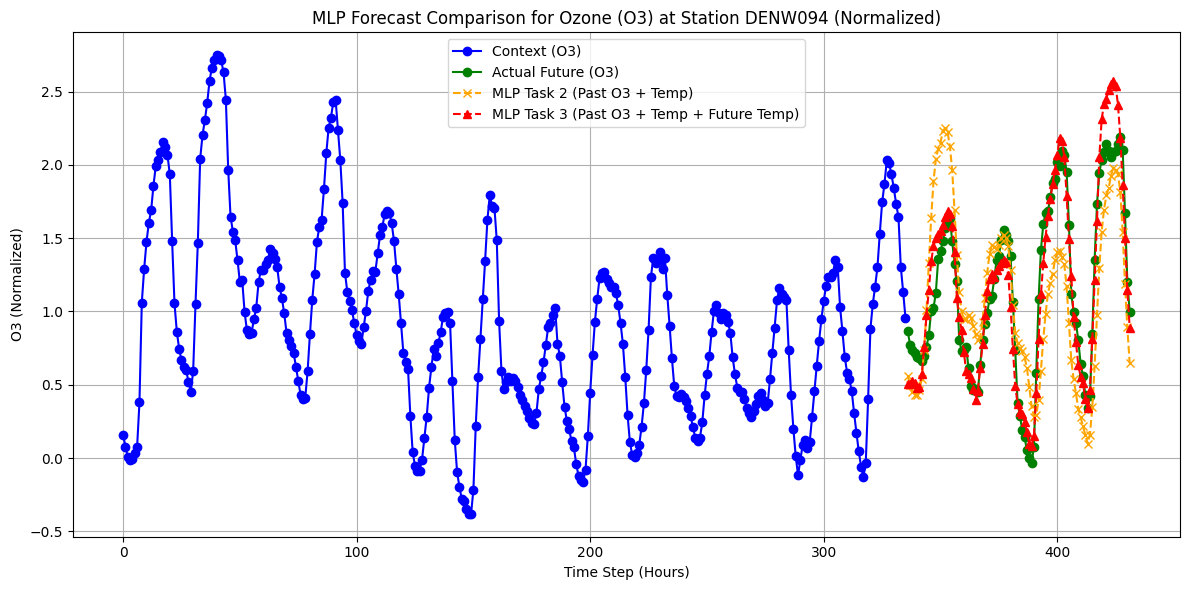

In [23]:
# Evaluate models
# Sample RMSE (DENW094)
print("Task 2 - DENW094 Sample:")
evaluate_model(y_test_sample, pred_task2)
print("Task 3 - DENW094 Sample:")
evaluate_model(y_test_sample, pred_task3)

# Full test set RMSE
print("Task 2 - Full Test Set:")
evaluate_model(y_test_o3, mlp_model.predict(X_test_flat))
print("Task 3 - Full Test Set:")
evaluate_model(y_test_o3, mlp_model_task3.predict(X_test_task3))

# Step 5: Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(range(336), X_test_sample, label="Context (O3)", color="blue", marker="o")
plt.plot(range(336, 336 + 96), y_test_sample, label="Actual Future (O3)", color="green", marker="o")
plt.plot(range(336, 336 + 96), pred_task2, label="MLP Task 2 (Past O3 + Temp)", linestyle="--", color="orange", marker="x")
plt.plot(range(336, 336 + 96), pred_task3, label="MLP Task 3 (Past O3 + Temp + Future Temp)", linestyle="--", color="red", marker="^")

plt.title("MLP Forecast Comparison for Ozone (O3) at Station DENW094 (Normalized)")
plt.xlabel("Time Step (Hours)")
plt.ylabel("O3 (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## What I Did
I started by setting up an MLP model (Task 2) to predict 96 hours of future O3 using 336 hours of past O3 and temperature data. Then, I created a new model (Task 3) that adds future temperature forecasts to improve the predictions. I trained both models on normalized data and used a plot to compare their performance for the DENW094 station. I also calculated RMSE to measure how close the predictions were to the actual values.

## Results
For the DENW094 sample, Task 2 had an RMSE of 0.4601, while Task 3 improved to 0.1910, showing a big jump in accuracy with future temperature. Across the full test set, Task 2's RMSE was 0.5875, and Task 3 dropped to 0.4703. The plot confirms Task 3 tracks the actual O3 better, especially at peaks, thanks to the extra temperature data.